In [1]:
import numpy as np
import pandas as pd
from ipypb import track

from polara.evaluation import evaluation_engine as ee
from polara.evaluation.pipelines import find_optimal_svd_rank
from polara import (SVDModel,
                    PopularityModel,
                    RandomModel)
from polara.recommender.hybrid.models import SimilarityAggregation
from polara.recommender.coldstart.models import (SVDModelItemColdStart,
                                                 RandomModelItemColdStart,
                                                 PopularityModelItemColdStart,
                                                 SimilarityAggregationItemColdStart)

from data_preprocessing import (get_amazon_data,
                                get_similarity_data,
                                prepare_data_model,
                                prepare_cold_start_data_model)
from utils import (report_results, save_results,
                   apply_config, print_data_stats,
                   save_training_time, save_cv_training_time)
%matplotlib inline

In [2]:
from polara.recommender import defaults
defaults.memory_hard_limit = 15 # allowed memory usage during recommendations generation

In [3]:
seed = 42

In [4]:
experiment_name = 'baseline'

# Experiment setup

In [5]:
data_labels = ['AMZe', 'AMZvg']

In [6]:
ranks_grid = [1, 5, 10, 15, 20, 30, 50, 60, 75, 100, 125, 150, 200, 250, 300,
              350, 400, 500, 750, 1000, 1250, 1500, 1750, 2000, 2500, 3000]
svd_ranks = {'AMZe': ranks_grid,
             'AMZvg': ranks_grid
            }

In [7]:
topk_values = [1, 3, 10, 20, 30]

In [8]:
target_metric = 'mrr'

In [9]:
data_dict = dict.fromkeys(data_labels)
meta_dict = dict.fromkeys(data_labels)
similarities = dict.fromkeys(data_labels)
sim_indices = dict.fromkeys(data_labels)
feature_idx = dict.fromkeys(data_labels)

In [10]:
all_data = [data_dict, similarities, sim_indices, meta_dict]

## Amazon Electronics

In [11]:
lbl = 'AMZe'

In [13]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('../datasets/amazon/ratings_Electronics.csv',
                                                 meta_path='../datasets/amazon/meta/meta_Electronics.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [14]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [15]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Amazon Video Games

In [16]:
lbl = 'AMZvg'

In [17]:
data_dict[lbl], meta_dict[lbl] = get_amazon_data('../datasets/amazon/ratings_Video_Games.csv',
                                                 meta_path='../datasets/amazon/meta/meta_Video_Games.json.gz',
                                                 implicit=True,
                                                 pcore=5,
                                                 filter_data={'categories': ['Games']}, # filter uniformative category
                                                 filter_no_meta=True,
                                                 flat_categories=True) # take only bottom level categories

In [18]:
similarities[lbl], sim_indices[lbl], feature_idx[lbl] = get_similarity_data(meta_dict[lbl])

In [19]:
(meta_dict[lbl].applymap(len).sum(axis=1)==0).mean()

0.0

## Data stats

In [20]:
print_data_stats(data_labels, all_data)

AMZe
{'userid': 124895, 'asin': 44843}
density 0.019153791836615672
similarity matrix density 1.1054998336712965
AMZvg
{'userid': 14251, 'asin': 6858}
density 0.13281340440589384
similarity matrix density 9.081814734274188


# Standard experiment

In [21]:
def prepare_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [SVDModel(data_model),
              SimilarityAggregation(data_model),
              PopularityModel(data_model),
              RandomModel(data_model, seed=seed)]
    apply_config(models, config, data_label)
    return models


def fine_tune_svd(model, ranks, label, record_time=False):
    best_svd_rank, svd_scores = find_optimal_svd_rank(model, ranks, target_metric,
                                                      return_scores=True,
                                                      iterator=lambda x: track(x, label=f'{label} ranks'))
    model_config = {model.method: {'rank': best_svd_rank}}
    model_scores = {model.method: svd_scores}
    try:
        if record_time:
            save_training_time(experiment_name, model, pd.Index([max(ranks)], name='rank'), label)
    finally:
        return model_config, model_scores

## tuning

In [22]:
config = {}
scores = {}
data_models = {}

In [23]:
for label in track(data_labels):
    data_models[label] = prepare_data_model(label, *all_data, seed)
    config[label], scores[label] = fine_tune_svd(SVDModel(data_models[label]),
                                                 svd_ranks[label],
                                                 label, True)

 [████████████████████████████████████████████████████████████] 2/2 [01:11:06<09:52, 2132.80s/it]

     AMZe ranks [█████████████████████████████████████████████] 26/26 [14:20<00:14, 33.07s/it]

    AMZvg ranks [█████████████████████████████████████████████] 26/26 [00:35<00:01, 1.33s/it]

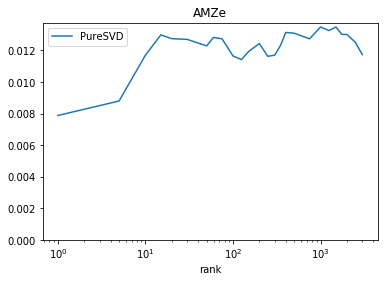

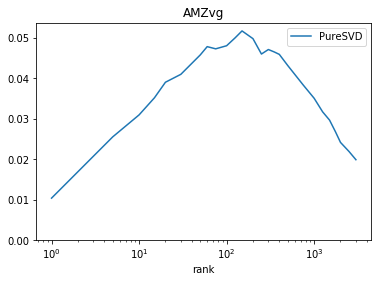

In [24]:
report_results('rank', scores);

In [25]:
config

{'AMZe': {'PureSVD': {'rank': 1000}}, 'AMZvg': {'PureSVD': {'rank': 150}}}

### saving data

In [26]:
save_results(experiment_name, config=config, tuning=scores)

## cross-validation

In [27]:
result = {}

for label in track(data_labels):
    models = prepare_recommender_models(label, data_models, config)
    result[label] = ee.run_cv_experiment(models,
                                         fold_experiment=ee.topk_test,
                                         topk_list=topk_values,
                                         ignore_feedback=True,
                                         iterator=lambda x: track(x, label=f'{label} folds'))
    save_cv_training_time(experiment_name, models, label)

 [████████████████████████████████████████████████████████████] 2/2 [59:53<00:52, 1796.25s/it]

     AMZe folds [█████████████████████████████████████████████] 5/5 [59:01<13:53, 708.10s/it]

    AMZvg folds [█████████████████████████████████████████████] 5/5 [00:52<00:09, 10.39s/it]

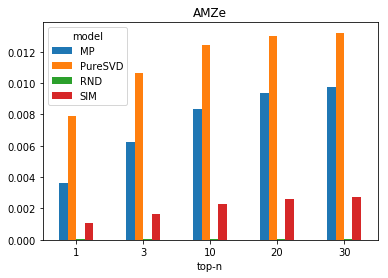

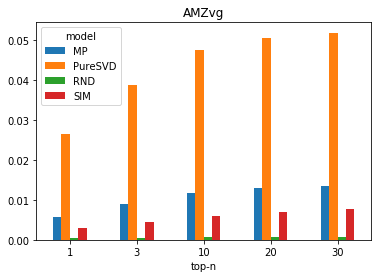

In [28]:
report_results('topn', result, target_metric);

### saving data

In [29]:
save_results(experiment_name, cv=result)

# Cold start

In [30]:
def prepare_cold_start_recommender_models(data_label, data_models, config):
    data_model = data_models[data_label]
    models = [SVDModelItemColdStart(data_model, item_features=meta_dict[data_label]),
              SimilarityAggregationItemColdStart(data_model),
              PopularityModelItemColdStart(data_model),
              RandomModelItemColdStart(data_model, seed=seed)]
    apply_config(models, config, data_label)
    return models

## tuning

In [31]:
config_cold = {}
scores_cold = {}
data_models_cold = {}

In [32]:
for label in track(data_labels):
    data_models_cold[label] = prepare_cold_start_data_model(label, *all_data, seed)
    model = SVDModelItemColdStart(data_models_cold[label],
                                  item_features=meta_dict[label])
    model.use_raw_features = True
    config_cold[label], scores_cold[label] = fine_tune_svd(model,
                                                           svd_ranks[label],
                                                           label)

 [████████████████████████████████████████████████████████████] 2/2 [01:16:57<07:44, 2308.39s/it]

     AMZe ranks [█████████████████████████████████████████████] 26/26 [16:07<00:17, 37.20s/it]

    AMZvg ranks [█████████████████████████████████████████████] 26/26 [00:45<00:00, 1.75s/it]

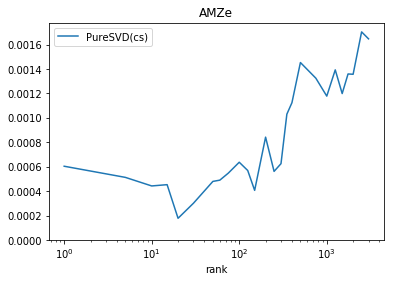

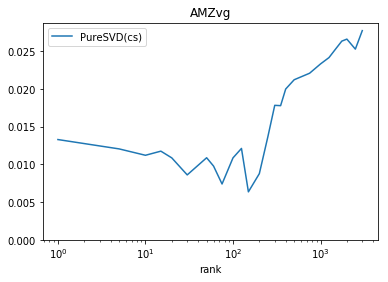

In [33]:
report_results('rank', scores_cold);

In [34]:
config_cold

{'AMZe': {'PureSVD(cs)': {'rank': 2500}},
 'AMZvg': {'PureSVD(cs)': {'rank': 3000}}}

### saving data

In [35]:
save_results(experiment_name+'_coldstart', config=config_cold, tuning=scores_cold)

## cross validation

In [36]:
result_cold = {}
for label in track(data_labels):
    models_cold = prepare_cold_start_recommender_models(label, data_models_cold, config_cold)
    result_cold[label] = ee.run_cv_experiment(models_cold,
                                              fold_experiment=ee.topk_test,
                                              topk_list=topk_values,
                                              ignore_feedback=True,
                                              iterator=lambda x: track(x, label=f'{label} folds'))

 [████████████████████████████████████████████████████████████] 2/2 [04:02:47<46:03, 7283.28s/it]

     AMZe folds [█████████████████████████████████████████████] 5/5 [03:16:43<39:14, 2360.61s/it]

    AMZvg folds [█████████████████████████████████████████████] 5/5 [46:03<07:48, 552.69s/it]

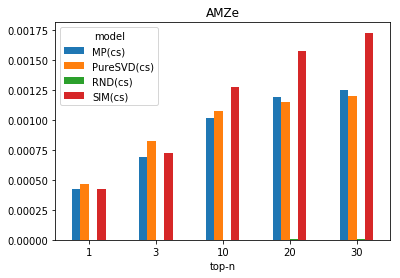

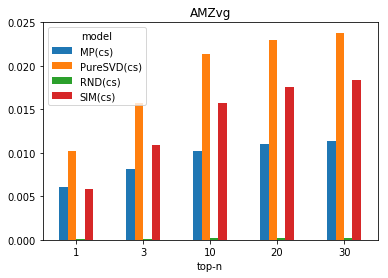

In [37]:
report_results('topn', result_cold, target_metric);

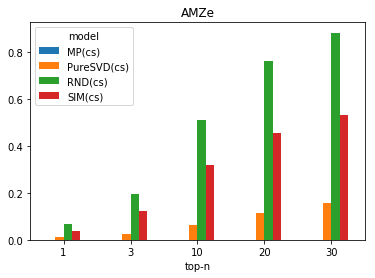

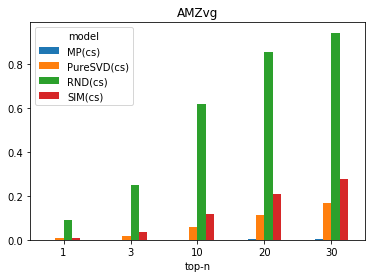

In [38]:
report_results('topn', result_cold, 'coverage');

### saving data

In [39]:
save_results(experiment_name+'_coldstart', cv=result_cold)